In [1]:
import numpy as np
import pandas as pd
import time
import gensim
import re
import cudl

from numba import jit, cuda
from gensim.models.word2vec import Word2Vec 
from nltk.tokenize import RegexpTokenizer 
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
tokenizer = TweetTokenizer()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from cuml import DBSCAN

C:\Users\adamr\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Data Cleansing

In [2]:
def stop_word_remover(df):
    df['text'] = df['text'].astype(str).str.lower()
    df['token_text'] = df['text'].str.replace('([^ a-zA-Z0-9])', '').str.replace('http\S+|www.\S+', '', case=False).replace('coronavirus', 
                                                                                                                            'covid19')

    stop = stopwords.words('english')
    df['stop_text'] = df['token_text'].apply(lambda x: [item for item in str(x).split() 
                                                    if item not in stop])
    
    return df

In [3]:
df1 = pd.read_csv('../adam/datasets/scrape_5.12.csv')
pd.set_option('display.max_colwidth', -1)

C:\Users\adamr\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [4]:
df1.shape

(121482, 10)

In [5]:
df1.drop_duplicates(inplace=True)
df1.shape

(114044, 10)

In [6]:
df1 = stop_word_remover(df1)

In [7]:
df2 = pd.read_csv('../adam/datasets/test_5.14.csv')
pd.set_option('display.max_colwidth', -1)

C:\Users\adamr\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [8]:
df2.shape

(221214, 10)

In [9]:
df2.drop_duplicates(inplace=True)
df2.shape

(201794, 10)

In [10]:
df2 = stop_word_remover(df2)

In [11]:
df = pd.concat([df1,df2], ignore_index = True, verify_integrity = True)
df.shape

(315838, 12)

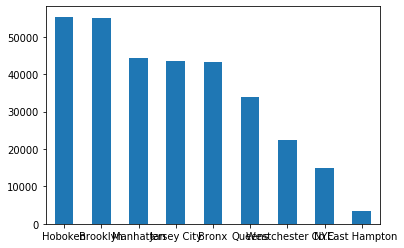

In [71]:
fig = figsize = (10,5)
ax = df['city'].value_counts().plot.bar(rot = 0)

In [12]:
df['text'].head()

0    did the first of several shopping runs, though i ended up walking out of cvs without buying anything. if the rate of people coughing at me is any indication, we’ll all have covid-19 by thursday. \n\ncover your fucking mouths when you cough.
1    looks like adios muchachos for the us #covid #covid19us #coronavirushttps://twitter.com/nytimes/status/1234171621696557057 …                                                                                                                    
2    humour..snl...on #covid #coronavirususahttps://mashable.com/video/snl-coronavirus-democratic-candidates-cold-open/ …                                                                                                                            
3    had to go to three diff convenient stores to find real milk (not soy) and they were all out of the lower priced non organic stuff .. i buy organic so i was fine with it but wow. covid 19 panic buying begins in manhattan.                    
4    #covid #cor

In [13]:
df['stop_text'].head()

0    [first, several, shopping, runs, though, ended, walking, cvs, without, buying, anything, rate, people, coughing, indication, well, covid19, thursday, cover, fucking, mouths, cough]
1    [looks, like, adios, muchachos, us, covid, covid19us, coronavirus]                                                                                                                  
2    [humoursnlon, covid, coronavirususa]                                                                                                                                                
3    [go, three, diff, convenient, stores, find, real, milk, soy, lower, priced, non, organic, stuff, buy, organic, fine, wow, covid, 19, panic, buying, begins, manhattan]              
4    [covid, coronovirius, nursing, home, setting, kirkland, 50, symptoms, 3120]                                                                                                         
Name: stop_text, dtype: object

In [14]:
df['token_text'].head()

0    did the first of several shopping runs though i ended up walking out of cvs without buying anything if the rate of people coughing at me is any indication well all have covid19 by thursday cover your fucking mouths when you cough
1    looks like adios muchachos for the us covid covid19us coronavirus                                                                                                                                                                    
2    humoursnlon covid coronavirususa                                                                                                                                                                                                     
3    had to go to three diff convenient stores to find real milk not soy and they were all out of the lower priced non organic stuff  i buy organic so i was fine with it but wow covid 19 panic buying begins in manhattan               
4    covid coronovirius in nursing home setting  kirkland mo

## Word Vectorizer

In [15]:
sent = [row for row in df1['stop_text']]

In [16]:
dims = 300

In [17]:
tweet_w2v = Word2Vec(size=dims, min_count=500, window=10)

In [18]:
tweet_w2v.build_vocab(sent)

In [19]:
tweet_w2v.most_similar('covid')

C:\Users\adamr\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('america', 0.1774219572544098),
 ('trumps', 0.15831056237220764),
 ('going', 0.1576019823551178),
 ('treatment', 0.1463635116815567),
 ('today', 0.13153408467769623),
 ('found', 0.12964557111263275),
 ('become', 0.12547096610069275),
 ('socialdistancing', 0.12408412247896194),
 ('already', 0.12144090980291367),
 ('says', 0.11682413518428802)]

## Tweet Vectorizer

In [20]:
# Functions found in this cell were created by instructor Noah Christiansen
# He is great
# Define vectorization function
#word2vecmodel = tweet_w2v
def vectorize_corpus(keyword_list):    
    # Instantiate counter for number of words in keyword_list that exists
    n_words = 0
    # Create template for cumulative corpus vector sum
    corpus_vec_sum = np.zeros((1,dims))                 
    # Scan through each word in list
    for word in keyword_list:
        if word in tweet_w2v.wv.vocab:                    
            word_vec = tweet_w2v.wv.word_vec(word)
            #print(word_vec)
            n_words +=1                                
            corpus_vec_sum = corpus_vec_sum + word_vec 
    # Compute average vector by taking cumulative vector sum and dividing it by number of words traced
    corpus_avg_vec = corpus_vec_sum/n_words
    # Squeeze this N-dimensional nested array object into a 1-D array to streamline future processing
    corpus_avg_vec = np.squeeze(corpus_avg_vec)
    return(corpus_avg_vec)

#defining cosine similarity function
def cos_sim(vector_1, vector_2):
    dp = np.dot(vector_1, vector_2)
    magnitude_v1 = np.sqrt(np.dot(vector_1,vector_1))
    magnitude_v2 = np.sqrt(np.dot(vector_2,vector_2))
    return(dp/(magnitude_v1*magnitude_v2))


In [21]:
vect_tweets = [vectorize_corpus(tweet) for tweet in df['stop_text']]
vect_df = pd.DataFrame(vect_tweets)

C:\Users\adamr\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [22]:
print(df.shape)
print(vect_df.shape)

(315838, 12)
(315838, 300)


In [23]:
join_df = df.join(vect_df)
join_df.dropna(inplace = True)
join_df.shape

(293497, 312)

In [24]:
clean_vec_df= join_df.iloc[:, [i for i in range(13,(dims+12))]]
clean_og_df = join_df.iloc[:, [i for i in range(0,12)]]
clean_vec_df.head()

,1,2,3,4,5,6,7,8,9,10,...,290,291,292,293,294,295,296,297,298,299
0,0.000036,-0.000318,-0.000159,-0.000425,0.000237,0.000169,-0.000201,-0.000051,-0.000067,0.000510,...,-0.000107,0.000111,0.000009,-0.000047,0.000154,-0.000091,-0.000100,0.000008,0.000212,0.000752
1,0.000184,-0.000228,0.000042,-0.000009,0.000122,-0.000426,-0.000161,-0.000141,0.000470,-0.000351,...,0.000646,0.000715,-0.000258,-0.000621,-0.000584,-0.000349,-0.000400,0.000185,0.000665,0.000882
2,0.000271,-0.000080,-0.001618,0.000013,-0.000597,-0.000060,-0.000231,-0.001556,-0.000579,-0.000073,...,0.000895,0.001244,0.000246,0.000535,-0.001173,-0.001518,-0.000017,-0.000595,0.001266,0.000610
3,0.000576,-0.000205,-0.000070,-0.000082,-0.000107,0.000277,0.000405,-0.000229,0.000167,-0.000346,...,0.000017,0.000487,0.000124,0.000656,-0.000577,-0.000370,0.000295,-0.000323,-0.000345,-0.000208
4,0.000431,-0.000456,-0.001382,0.000116,-0.000748,-0.000358,-0.000909,0.000350,0.000042,0.000065,...,0.000661,0.000008,-0.000140,-0.000209,-0.000455,0.000587,0.000043,0.000705,0.000736,0.000214


In [25]:
clean_og_df.head()

,tweet_id,username,text,tweet_date,search_term,city,lat,long,radius,query_start,token_text,stop_text
0,1234258409408602118,e.p.c.,"did the first of several shopping runs, though i ended up walking out of cvs without buying anything. if the rate of people coughing at me is any indication, we’ll all have covid-19 by thursday. \n\ncover your fucking mouths when you cough.",2020-03-01 23:25:10,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,did the first of several shopping runs though i ended up walking out of cvs without buying anything if the rate of people coughing at me is any indication well all have covid19 by thursday cover your fucking mouths when you cough,"[first, several, shopping, runs, though, ended, walking, cvs, without, buying, anything, rate, people, coughing, indication, well, covid19, thursday, cover, fucking, mouths, cough]"
1,1234253374725459968,@geminiwoe,looks like adios muchachos for the us #covid #covid19us #coronavirushttps://twitter.com/nytimes/status/1234171621696557057 …,2020-03-01 23:05:10,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,looks like adios muchachos for the us covid covid19us coronavirus,"[looks, like, adios, muchachos, us, covid, covid19us, coronavirus]"
2,1234241890700218370,enigma4ever 🌹🆘 🌊 🕊️🍑👩‍⚕️💉😷,humour..snl...on #covid #coronavirususahttps://mashable.com/video/snl-coronavirus-democratic-candidates-cold-open/ …,2020-03-01 22:19:32,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,humoursnlon covid coronavirususa,"[humoursnlon, covid, coronavirususa]"
3,1234238588474331136,° ° °,had to go to three diff convenient stores to find real milk (not soy) and they were all out of the lower priced non organic stuff .. i buy organic so i was fine with it but wow. covid 19 panic buying begins in manhattan.,2020-03-01 22:06:25,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,had to go to three diff convenient stores to find real milk not soy and they were all out of the lower priced non organic stuff i buy organic so i was fine with it but wow covid 19 panic buying begins in manhattan,"[go, three, diff, convenient, stores, find, real, milk, soy, lower, priced, non, organic, stuff, buy, organic, fine, wow, covid, 19, panic, buying, begins, manhattan]"
4,1234238537068883968,enigma4ever 🌹🆘 🌊 🕊️🍑👩‍⚕️💉😷,"#covid #coronovirius in nursing home setting , #kirkland more than 50 with symptoms ..3/1/20https://www.statnews.com/2020/02/29/new-covid-19-death-raises-concerns-about-virus-spread-in-nursing-homes/ …",2020-03-01 22:06:12,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,covid coronovirius in nursing home setting kirkland more than 50 with symptoms 3120,"[covid, coronovirius, nursing, home, setting, kirkland, 50, symptoms, 3120]"


In [51]:
dbscan = DBSCAN(metric='cosine', eps=0.4, min_samples=20, n_jobs = -1) # you can change these parameters, given just for example 
cluster_labels = dbscan.fit_predict(clean_vec_df) # where X - is your matrix, where each row corresponds to one document (line) from the docs, you need to cluster 

In [52]:
clean_og_df['cluster'] = cluster_labels

C:\Users\adamr\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [53]:
clean_og_df['cluster'].value_counts()

 0     242166
-1     50734 
 10    84    
 20    49    
 9     39    
 16    35    
 14    30    
 5     28    
 8     27    
 15    25    
 12    25    
 7     25    
 11    24    
 17    23    
 21    21    
 13    21    
 18    21    
 19    20    
 6     20    
 4     20    
 3     20    
 2     20    
 1     20    
Name: cluster, dtype: int64

In [54]:
clean_og_df.head(5)

,tweet_id,username,text,tweet_date,search_term,city,lat,long,radius,query_start,token_text,stop_text,cluster
0,1234258409408602118,e.p.c.,"did the first of several shopping runs, though i ended up walking out of cvs without buying anything. if the rate of people coughing at me is any indication, we’ll all have covid-19 by thursday. \n\ncover your fucking mouths when you cough.",2020-03-01 23:25:10,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,did the first of several shopping runs though i ended up walking out of cvs without buying anything if the rate of people coughing at me is any indication well all have covid19 by thursday cover your fucking mouths when you cough,"[first, several, shopping, runs, though, ended, walking, cvs, without, buying, anything, rate, people, coughing, indication, well, covid19, thursday, cover, fucking, mouths, cough]",-1
1,1234253374725459968,@geminiwoe,looks like adios muchachos for the us #covid #covid19us #coronavirushttps://twitter.com/nytimes/status/1234171621696557057 …,2020-03-01 23:05:10,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,looks like adios muchachos for the us covid covid19us coronavirus,"[looks, like, adios, muchachos, us, covid, covid19us, coronavirus]",0
2,1234241890700218370,enigma4ever 🌹🆘 🌊 🕊️🍑👩‍⚕️💉😷,humour..snl...on #covid #coronavirususahttps://mashable.com/video/snl-coronavirus-democratic-candidates-cold-open/ …,2020-03-01 22:19:32,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,humoursnlon covid coronavirususa,"[humoursnlon, covid, coronavirususa]",0
3,1234238588474331136,° ° °,had to go to three diff convenient stores to find real milk (not soy) and they were all out of the lower priced non organic stuff .. i buy organic so i was fine with it but wow. covid 19 panic buying begins in manhattan.,2020-03-01 22:06:25,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,had to go to three diff convenient stores to find real milk not soy and they were all out of the lower priced non organic stuff i buy organic so i was fine with it but wow covid 19 panic buying begins in manhattan,"[go, three, diff, convenient, stores, find, real, milk, soy, lower, priced, non, organic, stuff, buy, organic, fine, wow, covid, 19, panic, buying, begins, manhattan]",1
4,1234238537068883968,enigma4ever 🌹🆘 🌊 🕊️🍑👩‍⚕️💉😷,"#covid #coronovirius in nursing home setting , #kirkland more than 50 with symptoms ..3/1/20https://www.statnews.com/2020/02/29/new-covid-19-death-raises-concerns-about-virus-spread-in-nursing-homes/ …",2020-03-01 22:06:12,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,covid coronovirius in nursing home setting kirkland more than 50 with symptoms 3120,"[covid, coronovirius, nursing, home, setting, kirkland, 50, symptoms, 3120]",0


In [72]:
mask = clean_og_df['cluster'] == 10
clean_og_df[mask]['search_term'].value_counts()[:10]

#COVID      55
#covid19    27
COVID       2 
Name: search_term, dtype: int64

In [73]:
clean_og_df[mask].head(5)

,tweet_id,username,text,tweet_date,search_term,city,lat,long,radius,query_start,token_text,stop_text,cluster
1943,1250557400316248066,Ron Waxman 🏳️‍🌈,"i want everyone to understand this. in the midst of #coronaviruspandemic during which tens of thousands of americans are dying, trump’s biggest worry and complaint is getting judges approved! he is unfit for office. #trumppressconf #trumppressconference #covid19 #covid",2020-04-15 22:51:33,#COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,i want everyone to understand this in the midst of coronaviruspandemic during which tens of thousands of americans are dying trumps biggest worry and complaint is getting judges approved he is unfit for office trumppressconf trumppressconference covid19 covid,"[want, everyone, understand, midst, coronaviruspandemic, tens, thousands, americans, dying, trumps, biggest, worry, complaint, getting, judges, approved, unfit, office, trumppressconf, trumppressconference, covid19, covid]",10
1944,1250557334356725763,Ron Waxman 🏳️‍🌈,"i want everyone to understand this. in the midst of #coronaviruspandemic during which tens of thousands of americans are dying, trump’s biggest worry and complaint is getting judges approved! he is unfit for office. #trumppressconf #trumppressconference #covid19 #covid",2020-04-15 22:51:17,#COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,i want everyone to understand this in the midst of coronaviruspandemic during which tens of thousands of americans are dying trumps biggest worry and complaint is getting judges approved he is unfit for office trumppressconf trumppressconference covid19 covid,"[want, everyone, understand, midst, coronaviruspandemic, tens, thousands, americans, dying, trumps, biggest, worry, complaint, getting, judges, approved, unfit, office, trumppressconf, trumppressconference, covid19, covid]",10
1945,1250557294695366656,Ron Waxman 🏳️‍🌈,"i want everyone to understand this. in the midst of #coronaviruspandemic during which tens of thousands of americans are dying, trump’s biggest worry and complaint is getting judges approved! he is unfit for office. #trumppressconf #trumppressconference #covid19 #covid",2020-04-15 22:51:07,#COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,i want everyone to understand this in the midst of coronaviruspandemic during which tens of thousands of americans are dying trumps biggest worry and complaint is getting judges approved he is unfit for office trumppressconf trumppressconference covid19 covid,"[want, everyone, understand, midst, coronaviruspandemic, tens, thousands, americans, dying, trumps, biggest, worry, complaint, getting, judges, approved, unfit, office, trumppressconf, trumppressconference, covid19, covid]",10
1946,1250557259609972736,Ron Waxman 🏳️‍🌈,"i want everyone to understand this. in the midst of #coronaviruspandemic during which tens of thousands of americans are dying, trump’s biggest worry and complaint is getting judges approved! he is unfit for office. #trumppressconf #trumppressconference #covid19 #covid",2020-04-15 22:50:59,#COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,i want everyone to understand this in the midst of coronaviruspandemic during which tens of thousands of americans are dying trumps biggest worry and complaint is getting judges approved he is unfit for office trumppressconf trumppressconference covid19 covid,"[want, everyone, understand, midst, coronaviruspandemic, tens, thousands, americans, dying, trumps, biggest, worry, complaint, getting, judges, approved, unfit, office, trumppressconf, trumppressconference, covid19, covid]",10
1949,1250555276446572552,Ron Waxman 🏳️‍🌈,"i want everyone to understand this. in the midst of #coronaviruspandemic during which tens of thousands of americans are dying, trump’s biggest worry and complaint is getting judges approved! he is unfit for office. #trumppressconf #trumppressconference #covid19 #covid",2020-04-15 22:43:06,#COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,i want ev

In [56]:
clean_og_df.to_csv(r'./datasets/full_dataset.csv', compression = 'gzip')